# MISURE CON ARIA

In [10]:
import pandas as pd
import numpy as np
import os

dir_path = os.path.abspath('') #os.path.dirname(os.path.realpath(__file__))
FILE = dir_path + '/aria_dati_2.csv'
fr = pd.read_csv(FILE)

# m sta per media (valori aventi lo stesso flusso R)
# i valori medi sono stati calcolati con excel e occupano solo le prime 6 righe
p1 = np.array(fr['p1m'][:6]) * 1000 # kPa -> Pa
p2 = np.array(fr['p2m'][:6]) * 1000
p3 = np.array(fr['p3m'][:6]) * 1000
p4 = np.array(fr['p4m'][:6]) * 1000

# deviazioni standard
sp1 = np.array(fr['STD1'][:6]) * 1000
sp2 = np.array(fr['STD2'][:6]) * 1000
sp3 = np.array(fr['STD3'][:6]) * 1000
sp4 = np.array(fr['STD4'][:6]) * 1000

R = np.array(fr['Rm'][:6]) / 60000 # L/min litri per munuto -> m3/s

## calcolo velocità:

$R = cost = A_Lv_L = A_sv_s$

vL:  [0.41876047 0.54438861 0.67001675 0.79564489 0.92127303 1.04690117]
vs:  [1.84365782 2.39675516 2.94985251 3.50294985 4.0560472  4.60914454]


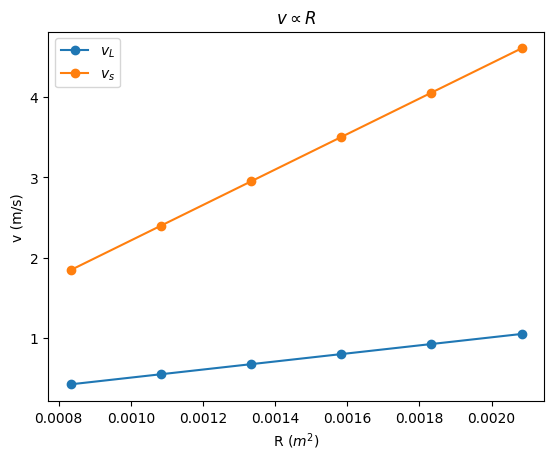

In [14]:
import matplotlib.pyplot as plt

AL = 1.99 / 1000 # m2
AS = 0.452 / 1000 # m2

vL = R / AL
vs = R / AS

print('vL: ',vL)
print('vs: ', vs)

plt.title('$v \propto R$')
plt.plot(R,vL,'o-', label='$v_L$')
plt.plot(R,vs,'o-', label='$v_s$')
plt.legend()
plt.xlabel('R ($m^2$)')
plt.ylabel('v (m/s)')
plt.show()

### VALORI DI PRESSIONE RACCOLTI

all'interno del tubo si verificano fenomeni di turbolenza che alterano il valore della pressione tra P1-P3 e P2-P4.

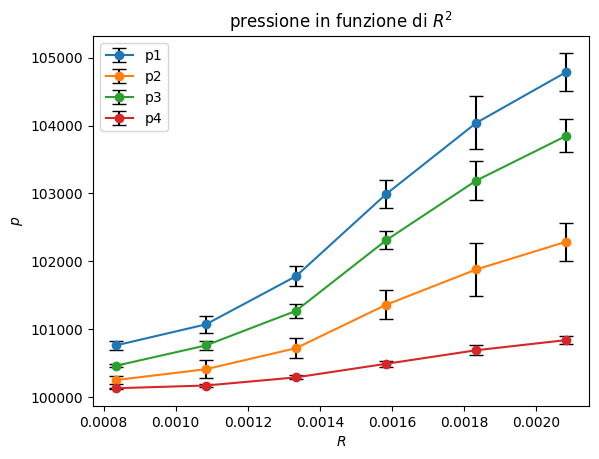

In [16]:
plt.title('pressione in funzione di $R^2$')
plt.errorbar(R,p1,fmt='o-',yerr=sp1,capsize=5, ecolor='black',label='p1')
plt.errorbar(R,p2,fmt='o-',yerr=sp1,capsize=5, ecolor='black',label='p2')
plt.errorbar(R,p3,fmt='o-',yerr=sp3,capsize=5, ecolor='black',label='p3')
plt.errorbar(R,p4,fmt='o-',yerr=sp4,capsize=5, ecolor='black',label='p4')
plt.xlabel('$R$')
plt.ylabel('$p$')
plt.legend()
plt.show()

Applichiamo le correzioni ai valori delle pressioni causati dalle turbolenze:

$P_L = P_1 \\$
$P_s = p_2 + \Delta P = P_2 + \frac{(P_1 - P_3)}{2} \\$
$P_L - P_s = P_1 - P_2 - \Delta P \\$

In [19]:
from interpolazione3 import final_val

pL, spL = p1, sp1

ps = p2 + (p1-p3)/2
sps = np.sqrt((sp2)**2 + (0.5 * sp1)**2 + (0.5*sp3)**2) # usando derivate parziali

PLPs, sPLPs = pL - ps, np.sqrt(spL**2 + sps**2)

print('pL: ',final_val(pL,spL))
print('ps:',final_val(ps,sps))
print('pL-ps: ',final_val(PLPs,sPLPs))


pL:  [100760. 101070. 101780. 102990. 104040. 104790.] ± [ 60. 130. 150. 210. 390. 280.] 
ps: [100400. 100565. 100975. 101700. 102305. 102760.] ± [ 59.16  87.32 103.08 137.3  280.45 231.52] 
pL-ps:  [ 360.  505.  805. 1290. 1735. 2030.] ± [ 84.26 156.6  182.   250.9  480.36 363.32] 


## Verifica con equzione di Bernoulli:

$p_L - p_s = \frac{1}{2}\rho(v_s^2-v_L^2)$

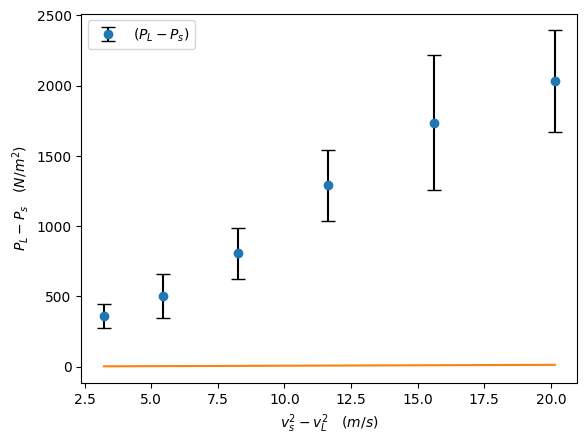

In [30]:
v = vs**2-vL**2 # asse x
rho = 1.255 # Kg/m3 densità dell'aria

x = np.linspace(min(v),max(v),100)
y = 0.5 * rho * x # retta attesa

plt.errorbar(v,PLPs,fmt='o',yerr=sPLPs,capsize=5, ecolor='black',label='$(P_L - P_s)$')
plt.plot(x,y)
plt.xlabel('$v_s^2-v_L^2 \quad (m/s)$')
plt.ylabel('$P_L - P_s \quad (N / m^2)$')
plt.legend()
plt.show()

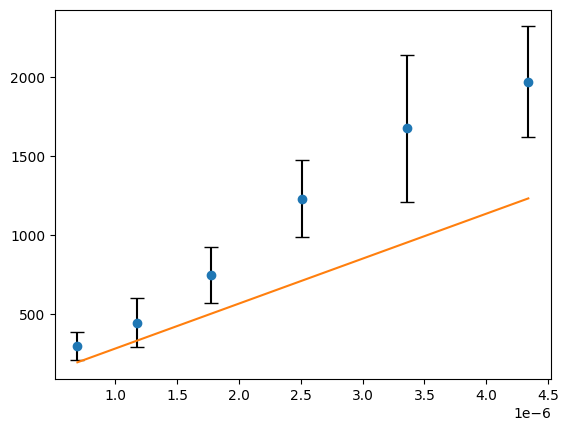

In [32]:
A_l = 1.99 / 10000 #cm^2 -> m^2 area larga
A_s = 0.452 / 10000 # area stretta


# offset per la pressione:
o1 = 0.249 * 1000
o2 = 0.166 * 1000
o3 = 0.198 * 1000
o4 = 0.300 * 1000

p_l = p1 - o1
p_S = p2 - o2 + (p1 - o1 - p3 + o3)/2
P_osservato = p_l - p_S

v_l = R / A_l
v_s = R / A_s
d_aria = 1.225 # kg/m^3
P_attesi = 0.5 * d_aria * ((1/A_s)**2 - (1/A_l)**2) * R**2 

# propagazione errori:
std_p1 = np.array([0.06,0.13,0.15,0.21,0.39,0.28]) * 1000
std_p2 = np.array([0.05,0.05,0.05,0.06,0.14,0.14]) * 1000
std_p3 = np.array([0.02,0.06,0.10,0.13,0.29,0.24]) * 1000

sigma_pl = std_p1
sigma_ps = np.sqrt(std_p2**2 + (np.sqrt(std_p1**2 + std_p2**2)/2)**2)
sigma_P_osservato = np.sqrt(sigma_pl**2 + sigma_ps**2)


# TODO: cambiare yerr

plt.errorbar(R**2,P_osservato,fmt='o',yerr=sigma_P_osservato,capsize=5, ecolor='black',label='$\Delta p$')
plt.plot(R**2,P_attesi)

# a questo punto i nostri avventurieri si accorsero che nelle prime 4 righe di consegna specificava che il flusso dovesse essere compreso fra 10 e 60 L/min, rifecero le misure

il rimpianto e lo sgomento all'accorgersi che alle 14.55 avevano sprecato 4 ore di misurazioni per valori del tutto errati li portò a rivalutare il proprio percorso di fisici e diventare panettieri.

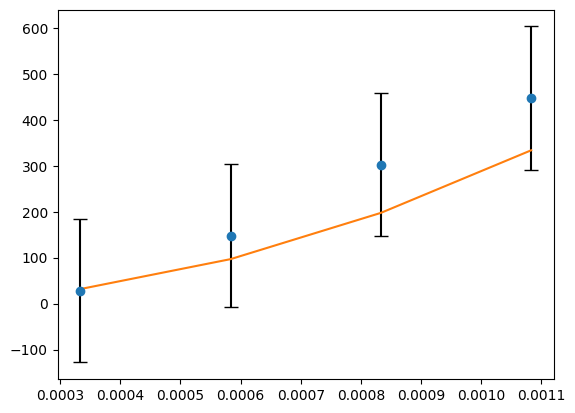

In [33]:
FILE = dir_path + '/aria_dati_3.csv'
fr = pd.read_csv(FILE)

p1 = np.array(fr['p1']) * 1000 # kPa -> Pa
p2 = np.array(fr['p2']) * 1000
p3 = np.array(fr['p3']) * 1000
p4 = np.array(fr['p4']) * 1000
R = np.array(fr['R']) / 60000 # L/min listri per munuto

p_l = p1 - o1
p_S = p2 - o2 + (p1 - o1 - p3 + o3)/2
P_osservato = p_l - p_S

v_l = R / A_l
v_s = R / A_s

P_attesi = 0.5 * d_aria * ((1/A_s)**2 - (1/A_l)**2) * R**2 

# TODO: cambiare yerr
plt.errorbar(R,P_osservato,fmt='o',yerr=sigma_P_osservato[1],capsize=5, ecolor='black',label='$\Delta p$')
plt.plot(R,P_attesi)

In [34]:
dp_1 = p1-p3
dp_2 = p2-p4
print(dp_1,dp_2)

print(p1,p2,p3,p4)

[-10. 170. 300. 310.] [ 10.  50. 120. 240.]
[100090. 100390. 100760. 101070.] [100010. 100100. 100250. 100410.] [100100. 100220. 100460. 100760.] [100000. 100050. 100130. 100170.]
